<center><h1> Building a Linear Model to Predict Housing Prices </h1></center>

---


## Packages Used:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulating and Storing Data
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)

# Machine Learning
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## Loading Data and EDA:

In [2]:
! ls

Housing Data Class Challenge Q1&Q2.ipynb
Housing Data Class Challenge.ipynb
Housing Data Walkthrough (Advanced).ipynb
Housing Data Walkthrough - Part III.ipynb
Housing Data Walkthrough Part III (advanced).ipynb
Housing Data Walkthrough Part III.ipynb
Subplotting and EDA.ipynb
melb_data.csv


In [3]:
df = pd.read_csv('melb_data.csv')
display(df.head(3))
print(f'Data Frame has: \n{df.shape[0]} rows \n{df.shape[1]} columns')


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


Data Frame has: 
13580 rows 
21 columns


A good thing to do to get a better understanding of each column is to check how many unique values are present in the respective columns. Columns with smaller numbers of unique values are generally categorical while columns with large numbers are generally numeric. This will also give us a feel for what columns it would make sense to plot.

In [4]:
print("Unique Values by Column")
for col in df.columns:
    print(f"{col}: {len(df[col].unique())}")

Unique Values by Column
Suburb: 314
Address: 13378
Rooms: 9
Type: 3
Price: 2204
Method: 5
SellerG: 268
Date: 58
Distance: 202
Postcode: 198
Bedroom2: 12
Bathroom: 9
Car: 12
Landsize: 1448
BuildingArea: 603
YearBuilt: 145
CouncilArea: 34
Lattitude: 6503
Longtitude: 7063
Regionname: 8
Propertycount: 311


In [5]:
categorical_columns = [col for col in df.columns if len(df[col].unique())<40]
categorical_columns

['Rooms',
 'Type',
 'Method',
 'Bedroom2',
 'Bathroom',
 'Car',
 'CouncilArea',
 'Regionname']

In [6]:
# Label encoding RegionName to avoid overly verbose outputs...we will cover this later.
df['Regionname'] , _ = pd.factorize(df['Regionname'])

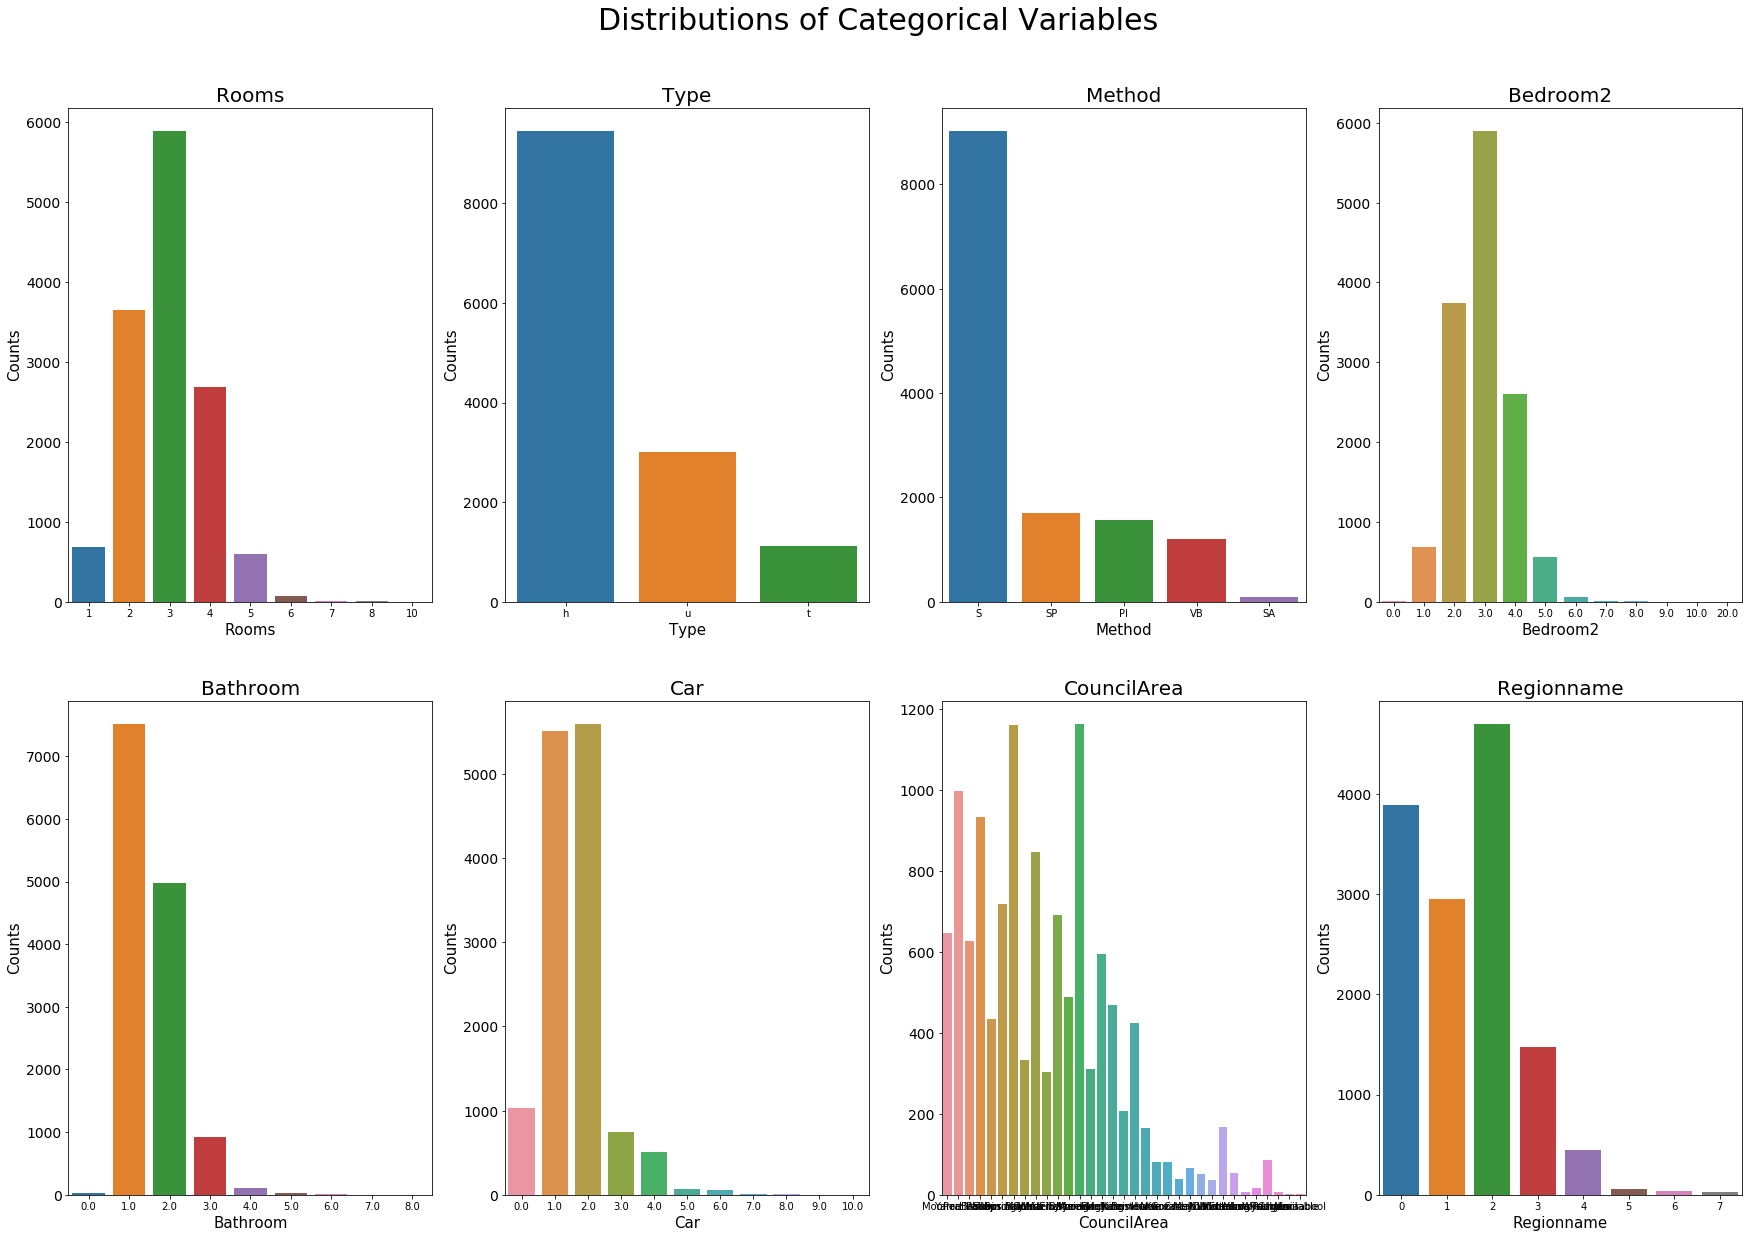

In [7]:
f,axes = plt.subplots(2,4,figsize=(30,20))
axes = axes.ravel()
for i,col in enumerate(categorical_columns):
    sns.countplot(df[col],ax=axes[i])
    axes[i].set_title(f'{col}',size=20)
    axes[i].set_xlabel(col,size=15)
    axes[i].set_ylabel('Counts',size=15)
    axes[i].tick_params(axis='y', labelsize=14)
plt.suptitle('Distributions of Categorical Variables',
             size=30,
             y=0.95)
plt.show()

Rooms and Bedroom2 appear to be duplicates of each other so we can drop one of these columns. From the distributions we can see a few things right away. Most houses have three bedrooms and 1-2 bathrooms. A vast majority of houses contain 1-2 cars (likely parking spaces).

In [8]:
df = df.drop(columns=['Bedroom2'])

# Numeric Plots and Suspicious Values

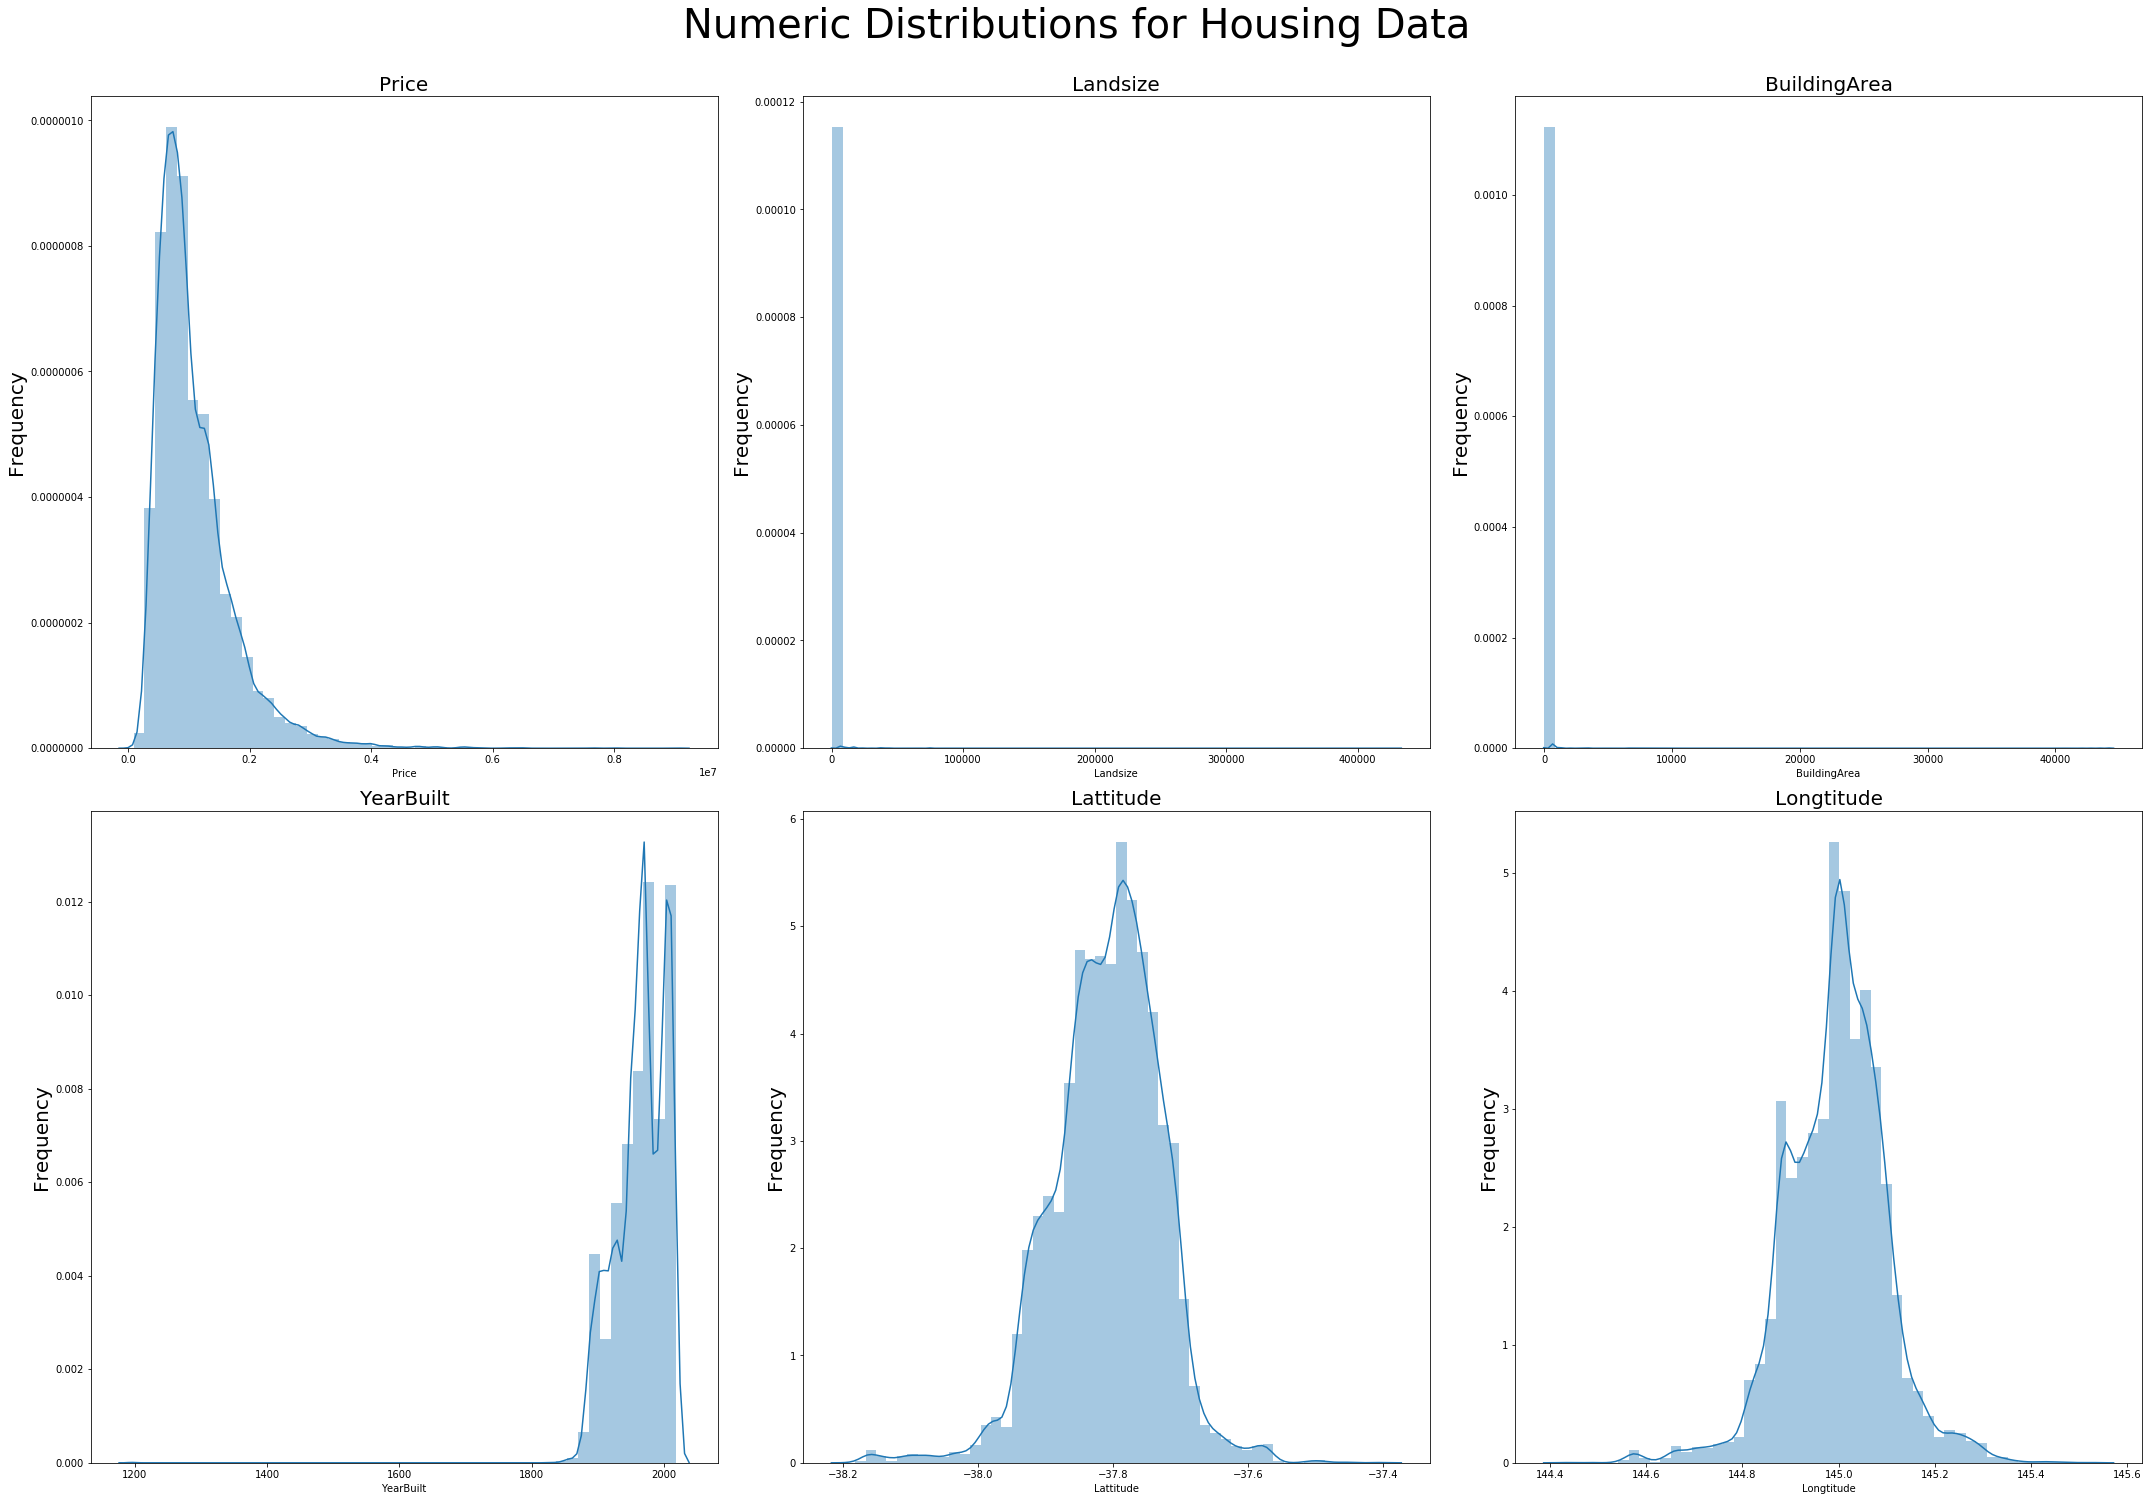

In [9]:
numeric_columns = ['Price','Landsize','BuildingArea','YearBuilt','Lattitude','Longtitude']

f,axes = plt.subplots(2,3,figsize=(30,20))
axes = axes.ravel()

for i,col in enumerate(numeric_columns):
    sns.distplot(df[col].dropna(),ax=axes[i])
    axes[i].set_title(col,size=20)
    axes[i].set_ylabel('Frequency',size=20)
    axes[i].tick_params(axis='y', labelsize=10)
plt.suptitle("Numeric Distributions for Housing Data",size=40,y=1.04)
plt.tight_layout()
plt.show()

Landsize and BuildingArea appear heavily skewed. Lets plot them outliers to find out more.

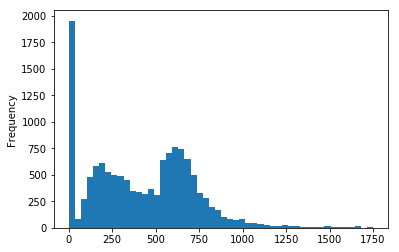

In [10]:
case = df['Landsize'] < df['Landsize'].median()*4
df[case]['Landsize'].plot.hist(bins=50)

The landsize column contains a ton of zeros but no NaNs which seems to indicate Nans were entered as zeros. For now we will map 0s to NaNs which we can replace later.

In [11]:
df['Landsize'] = df['Landsize'].replace(0,np.nan)

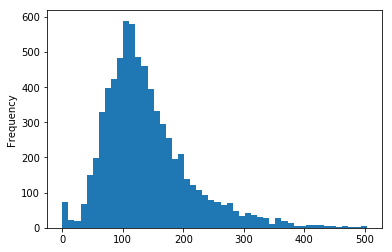

In [12]:
case = df['BuildingArea'] < df['BuildingArea'].median()*4
df[case]['BuildingArea'].plot.hist(bins=50)

In [13]:
df['BuildingArea'] = df['BuildingArea'].replace(0,np.nan)

## Bivariate and Multi Variate Analysis

The first example of a multivariate analysis that many of you are already familar with is the heatmap, which is often used to plot correlation matrices.

### Heatmaps and Barplots to Show Variable Correlations

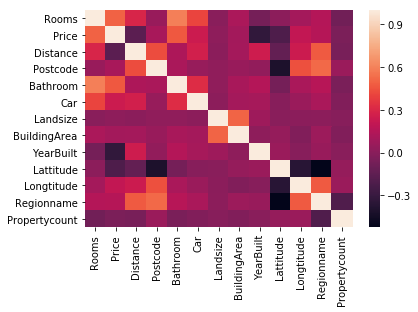

In [14]:
corrs = df.corr()
sns.heatmap(corrs)

Though this technically "shows" a lot of info its not the most helpful when we have a ton of different variables. If we are only concerned with how features correlate to our target variable, in this case Price, a bar plot may be a better choice.

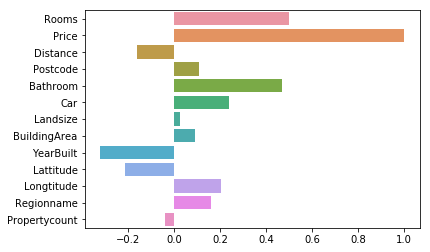

In [15]:
corrs = df.corr()['Price']

sns.barplot(y=corrs.index, x=corrs.values)

This is a little better better but we can still add some more order to our plot.

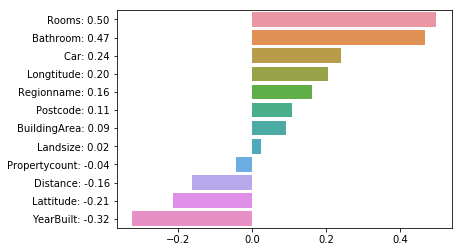

In [16]:
#First lets sort the values and drop the price column (which will be the most correlated)
corrs = corrs.sort_values(ascending=False)[1:]

# Now lets add the correlation values to our ylabels with a list comprehension
def show_corr(corrs):
    return [f'{a}: {b:.2f}' for a,b in zip(corrs.index,corrs.values)]

sns.barplot(y=show_corr(corrs), x=corrs.values)

If we only care about the predictive power of our variables we can use absolutes and sort that way.

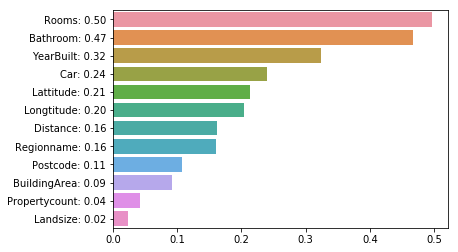

In [17]:
corrs = np.abs(corrs).sort_values(ascending=False)
sns.barplot(y=show_corr(corrs), x=corrs.values)

This gives us a much better view of which features will be most useful when trying to predict our target. We see that the number of Rooms and Bathrooms is heavily correlated with the price and other categories such as Year Built and # Cars holds some weight as well. We will save our correlations into a dataframe to use later.

In [18]:
corr_df = pd.DataFrame(corrs).reset_index()
corr_df.columns = ['Feature','Correlation']

---
## Cleaning Data

Now that we have a better feel for our data we can start to deal with some of the Nans present in it

In [19]:
nan_cols = [col for col in df.columns if df[col].isna().any()]
df[nan_cols].isna().sum()

Car               62
Landsize        1939
BuildingArea    6467
YearBuilt       5375
CouncilArea     1369
dtype: int64

The best thing to do for the numeric columns is to fill them with a central value. We can assume that properties in different postcodes will have different mean values so we will fill our numeric columns based on the median of its respective postcode to give us the most precise representation of similar houses.

### Filling Numeric Columns with Median Values of its Respective Postal Code

In [20]:
def fill_median_by_category(df,nan_column,category):    
    means = df.groupby(category)[nan_column].median()
    df.set_index([category],inplace=True)
    df[nan_column] = df[nan_column].fillna(means)
    df.reset_index(inplace=True)
    print(f"Filled NaNs in '{nan_column}' column with medians of respective '{category}' category")
    return

nan_cols.remove('CouncilArea')

for col in nan_cols:
    fill_median_by_category(df,col,'Postcode')

Filled NaNs in 'Car' column with medians of respective 'Postcode' category
Filled NaNs in 'Landsize' column with medians of respective 'Postcode' category
Filled NaNs in 'BuildingArea' column with medians of respective 'Postcode' category
Filled NaNs in 'YearBuilt' column with medians of respective 'Postcode' category


In [21]:
df[nan_cols].isna().sum()

Car              0
Landsize         4
BuildingArea     6
YearBuilt       10
dtype: int64

We were missing information for some postalcodes lets see if 'Regionname' can be used on the rest of the nan values

In [22]:
for col in nan_cols:
    fill_median_by_category(df,col,'Regionname')

Filled NaNs in 'Car' column with medians of respective 'Regionname' category
Filled NaNs in 'Landsize' column with medians of respective 'Regionname' category
Filled NaNs in 'BuildingArea' column with medians of respective 'Regionname' category
Filled NaNs in 'YearBuilt' column with medians of respective 'Regionname' category


In [23]:
df[nan_cols].isna().sum()

Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
dtype: int64

The NaN values in our numeric columns have all been taken care of, now we can move on to filling the categorical values ('CouncilArea') with the mode of its respective postal code.

In [24]:
# This is actually a little tedious
df = df.set_index('Postcode')
gdf = df.groupby('Postcode')['CouncilArea'].apply(lambda x: x.mode())
gdf = gdf.reset_index().drop(columns = 'level_1').set_index('Postcode')
df['CouncilArea'] = df['CouncilArea'].fillna(gdf['CouncilArea'])
df = df.reset_index()
print('Remaining Nans:',df['CouncilArea'].isna().sum())

Remaining Nans: 3


This got rid of most of the NaNs, for the last few we will fill with the mode of the entire data set.

In [25]:
fill = df['CouncilArea'].mode()[0]
df['CouncilArea'] = df['CouncilArea'].fillna(fill)

## Training a Basic Linear Model

In [26]:
# Create list of dependent features to use in baseline model
features = ['Rooms',
            'Distance',
            'Bathroom',
            'Car',
            'Landsize',
            'BuildingArea',
            'Lattitude',
            'Longtitude',
            'YearBuilt']

# identify target (independent) variable
target = 'Price'

x = df[features]
y = df[target]

# Train linear model
lnrg = linear_model.LinearRegression()
lin_model = lnrg.fit(x,y)

In [27]:
# We can calculate loss values to better evaluate model performance
def rmse(x,y):
    return mean_squared_error(x,y)**0.5

def score_model(model,x,y):
    print('R-Squared',model.score(x,y))
    print('RMSE:',rmse(model.predict(x),y))
    return

score_model(lin_model,x,y)

R-Squared 0.5185862142119754
RMSE: 443562.94693923293


The model can explain ~51% of the variance in housing price. We can use this to evaluate the performance of our future model when compared to a baseline. Lets add some of our categorical variables to see if they can help in predicting prices.

In [28]:
# Get list of categorical variables to one hot encode
new_features = ['Type','Method','Regionname']
ndf = pd.get_dummies(df,columns=new_features)

# We can get a list of our new columns using a list comprehension
encoded_columns = [column for column in ndf.columns if column not in df.columns]

# Our new featuer list will be our old features plus the encoded features
nfeatures = features + encoded_columns

In [29]:
# Train a linear model with new features
nx = ndf[nfeatures]
ny = ndf[target]
nlnrg = linear_model.LinearRegression()
nlin_model = nlnrg.fit(nx,ny)

# Measure the performance and compare to baseline
print('Model I:')
score_model(lin_model,x,y)
print('\nModel II:')
score_model(nlin_model,nx,ny)

Model I:
R-Squared 0.5185862142119754
RMSE: 443562.94693923293

Model II:
R-Squared 0.6040253025310491
RMSE: 402281.181250398


Adding our three categorical variable increased our R-Squared score by ~8%, a huge improvement over our baseline model.

---